# Inferring Pulsation Modes and Parameters with JAX

This notebook demonstrates how to infer pulsation mode parameters from synthetic spectroscopic observations using JAX-based optimization.

In [ ]:
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import astropy.units as u

from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, _add_pulsation, evaluate_pulsations
from spice.spectrum import simulate_observed_flux, GaussianLineEmulator

# Enable 64-bit precision for better numerical stabilit

%matplotlib inline


float_dtype: <class 'jax.numpy.float64'>


ImportError: cannot import name 'GaussianLineEmulator' from 'spice.spectrum' (/scratch/y89/mj8805/miniforge/envs/astro/lib/python3.12/site-packages/spice/spectrum/__init__.py)

## 1. Generate Synthetic Observations

First, we'll create synthetic "observed" data with known pulsation parameters that we'll try to recover.


In [2]:
# True parameters we'll try to recover
TRUE_L = 3
TRUE_M = 2
TRUE_AMPLITUDE = 1e-2
TRUE_FREQUENCY = 1.0
TRUE_PHASE = 0.0

print(f"True parameters:")
print(f"  l={TRUE_L}, m={TRUE_M}")
print(f"  Amplitude={TRUE_AMPLITUDE}")
print(f"  Frequency={TRUE_FREQUENCY}")
print(f"  Phase={TRUE_PHASE}")


True parameters:
  l=3, m=2
  Amplitude=0.01
  Frequency=1.0
  Phase=0.0


In [3]:
# Setup spectral line emulator
ge = GaussianLineEmulator(
    line_centers=[5500.0],
    line_widths=[0.3],
    line_depths=[0.5]
)

# Wavelength grid (in log10 space)
wvs = jnp.log10(jnp.linspace(5498, 5502, 1000))

# Time sampling
N_TIMES = 15
TIMESTAMPS = jnp.linspace(0., 2., N_TIMES)

print(f"Wavelength grid: {len(wvs)} points")
print(f"Time sampling: {N_TIMES} epochs")


Wavelength grid: 1000 points
Time sampling: 15 epochs


In [4]:
# Create model with true pulsation parameters
print("Generating synthetic observations...")
m_true = IcosphereModel.construct(
    1000, 1., 1.,
    ge.to_parameters(), 
    ge.parameter_names,
    max_pulsation_mode=20
)

# Add the true pulsation mode
m_true = add_pulsation(
    m_true, 
    l_degree=TRUE_L, 
    m_order=TRUE_M, 
    period=TRUE_FREQUENCY,
    fourier_series_parameters=jnp.array([[TRUE_AMPLITUDE, TRUE_PHASE]])
)

# Generate "observed" spectra
observed_spectra = []
for t in tqdm(TIMESTAMPS):
    mp = evaluate_pulsations(m_true, t)
    spec = simulate_observed_flux(ge.intensity, mp, wvs)
    observed_spectra.append(spec)

observed_spectra = jnp.array(observed_spectra)
print(f"Generated {len(observed_spectra)} spectra with shape {observed_spectra[0].shape}")


Generating synthetic observations...


/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
100%|██████████| 15/15 [00:23<00:00,  1.56s/it]


Generated 15 spectra with shape (1000, 2)


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_91676/2392689621.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


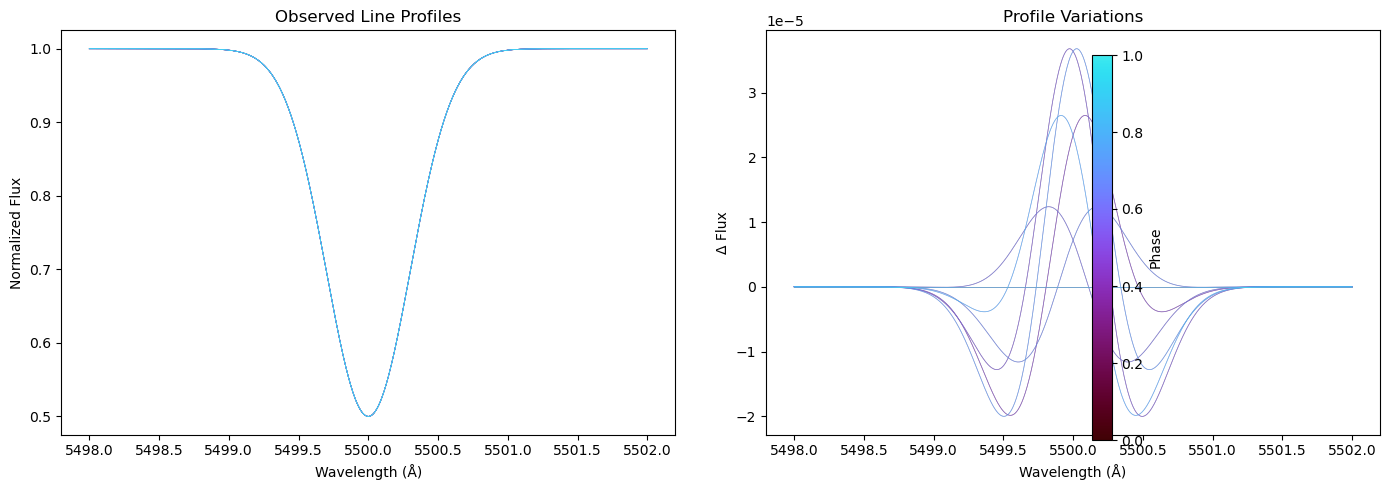

In [5]:
# Visualize the observations
import cmasher as cmr

phases = (TIMESTAMPS - TIMESTAMPS[0]) / (TIMESTAMPS[-1] - TIMESTAMPS[0])
norm = plt.Normalize(phases.min(), phases.max())
cmap = cmr.gem

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot normalized profiles
for spec, phase in zip(observed_spectra, phases):
    profile = spec[:, 0] / spec[:, 1]
    ax1.plot(10**wvs, profile, color=cmap(norm(phase)), alpha=0.6, lw=0.5)

ax1.set_xlabel('Wavelength (Å)')
ax1.set_ylabel('Normalized Flux')
ax1.set_title('Observed Line Profiles')

# Plot profile variations
base_profile = observed_spectra[0, :, 0] / observed_spectra[0, :, 1]
for spec, phase in zip(observed_spectra, phases):
    profile = spec[:, 0] / spec[:, 1]
    ax2.plot(10**wvs, profile - base_profile, color=cmap(norm(phase)), alpha=0.6, lw=0.5)

ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('Δ Flux')
ax2.set_title('Profile Variations')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(phases)
fig.colorbar(sm, ax=[ax1, ax2], label='Phase')
plt.tight_layout()
plt.show()


## 2. Set Up Inference Framework

Now we'll define the forward model and loss function for parameter inference using JAX.


In [6]:
# Create a base model (without pulsations) that we'll use for inference
from functools import partial


m_base = IcosphereModel.construct(
    1000, 1., 1.,
    ge.to_parameters(), 
    ge.parameter_names,
    max_pulsation_mode=20
)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [24]:
from functools import partial
import jax
import jax.numpy as jnp
from jax import vmap, value_and_grad
import optax

from spice.models.mesh_model import create_harmonics_params
from spice.models.mesh_transform import calculate_pulsations
from spice.models.utils import evaluate_many_fouriers_for_value, evaluate_many_fouriers_prim_for_value


# ===============================================================
# Pulsation evaluator — JIT with static harmonic count
# ===============================================================
@partial(jax.jit, static_argnames=("max_pulsation_mode",))
def evaluate_pulsations_static(m, t: float, max_pulsation_mode: int):
    t = jnp.nan_to_num(t)
    fourier_params = jnp.nan_to_num(m.fourier_series_parameters)

    pulsation_magnitudes = evaluate_many_fouriers_for_value(
        jnp.nan_to_num(m.pulsation_periods),
        fourier_params[:, :, 0],
        fourier_params[:, :, 1],
        t,
    )

    pulsation_velocity_magnitudes = evaluate_many_fouriers_prim_for_value(
        jnp.nan_to_num(m.pulsation_periods),
        fourier_params[:, :, 0],
        fourier_params[:, :, 1],
        t,
    )

    harmonic_params = create_harmonics_params(max_pulsation_mode)

    vert_offsets, area_offsets, center_offsets, pulsation_velocities = jax.vmap(
        calculate_pulsations,
        in_axes=(None, 0, 0, 0, None, 0, 0),
    )(
        m,
        harmonic_params,
        pulsation_magnitudes,
        pulsation_velocity_magnitudes,
        m.radius,
        m.pulsation_axes,
        m.pulsation_angles,
    )

    return m._replace(
        vertices_pulsation_offsets=jnp.nan_to_num(jnp.sum(vert_offsets, axis=0)),
        center_pulsation_offsets=jnp.nan_to_num(jnp.sum(center_offsets, axis=0)),
        area_pulsation_offsets=jnp.nan_to_num(jnp.sum(area_offsets, axis=0)),
        pulsation_velocities=jnp.nan_to_num(
            jnp.sum(pulsation_velocities, axis=0) * 8.052083333333332  # solRad/day → km/s
        ),
    )


# ===============================================================
# Forward model
# ===============================================================
@partial(jax.jit, static_argnames=("ge", "max_pulsation_mode"))
def forward_model(params, m_mode, l_mode, timestamps, ge, max_pulsation_mode):
    amplitude, period, phase = params
    fourier_series_parameters = jnp.array([[amplitude, phase]])

    total_pad_len = int(m_base.max_fourier_order - fourier_series_parameters.shape[0])

    m = _add_pulsation(
        m_base,
        jnp.array([m_mode, l_mode]),
        period,
        fourier_series_parameters,
        total_pad_len,
        m_base.rotation_axis,
        0.0,
    )

    def compute_spectrum(t):
        mp = evaluate_pulsations_static(m, t, max_pulsation_mode)
        return simulate_observed_flux(ge.intensity, mp, wvs)

    return vmap(compute_spectrum)(timestamps)


# ===============================================================
# Loss function
# ===============================================================
@partial(jax.jit, static_argnames=("ge", "max_pulsation_mode"))
def _loss_function(params, m_mode, l_mode, timestamps, observed, ge, max_pulsation_mode):
    model_spectra = forward_model(params, m_mode, l_mode, timestamps, ge, max_pulsation_mode)
    model_profiles = model_spectra[:, :, 0] / model_spectra[:, :, 1]
    obs_profiles = observed[:, :, 0] / observed[:, :, 1]
    residuals = model_profiles - obs_profiles
    return jnp.sum(residuals**2)


def loss_function(params, m_mode, l_mode, timestamps, observed, ge, max_pulsation_mode):
    valid = (l_mode >= 0) & (m_mode >= 0) & (m_mode <= l_mode)
    return jax.lax.cond(
        valid,
        lambda _: _loss_function(params, m_mode, l_mode, timestamps, observed, ge, max_pulsation_mode),
        lambda _: jnp.array(jnp.inf, dtype=jnp.float32),
        operand=None,
    )

In [30]:
import jax
import jax.numpy as jnp
from jax import value_and_grad, lax
import optax
from functools import partial

# ================================================================
# Loss function (as before)
# ================================================================
@partial(jax.jit, static_argnames=("ge", "max_pulsation_mode"))
def loss_function(params, m_mode, l_mode, timestamps, observed, ge, max_pulsation_mode):
    model_spectra = forward_model(params, m_mode, l_mode, timestamps, ge, max_pulsation_mode)
    model_profiles = model_spectra[:, :, 0] / model_spectra[:, :, 1]
    obs_profiles = observed[:, :, 0] / observed[:, :, 1]
    residuals = model_profiles - obs_profiles
    return jnp.sum(residuals**2)


# ================================================================
# Optimization loop (Adam + exponential LR decay)
# ================================================================
def optimize_params(
    timestamps,
    observed_spectra,
    ge,
    max_steps: int = 1000,
    lr_init: float = 1e-3,
    decay_rate: float = 0.95,
    decay_steps: int = 100,
):
    max_pulsation_mode = int(m_base.max_pulsation_mode)

    def objective(params):
        return loss_function(
            params,
            2,  # m
            3,  # l
            timestamps,
            observed_spectra,
            ge,
            max_pulsation_mode,
        )

    # --- Learning rate schedule ---
    lr_schedule = optax.exponential_decay(
        init_value=lr_init,
        transition_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=False,
    )

    # --- Adam optimizer with schedule ---
    optimizer = optax.adam(lr_schedule)

    init_params = jnp.array([5e-3, 0.8, 0.1], dtype=jnp.float64)
    opt_state = optimizer.init(init_params)

    @jax.jit
    def train_step(carry, step_idx):
        params, opt_state = carry
        loss, grads = value_and_grad(objective)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        lr = lr_schedule(step_idx)
        return (params, opt_state), (loss, lr)

    # --- Fully JIT-compiled scan loop ---
    (final_params, _), (losses, lrs) = lax.scan(
        train_step,
        (init_params, opt_state),
        jnp.arange(max_steps),
    )

    return final_params, losses, lrs

In [31]:
def objective(params):
    return loss_function(
        params,
        2,  # m
        3,  # l
        TIMESTAMPS,
        observed_spectra,
        ge,
        m_base.max_pulsation_mode,
    )
loss, grads = jax.value_and_grad(objective)(jnp.array([5e-3, 0.8, 0.1], dtype=jnp.float64))
jax.tree_map(lambda x: print(type(x)), grads)


<class 'jaxlib.xla_extension.ArrayImpl'>


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_91676/1660127914.py:12: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(lambda x: print(type(x)), grads)


In [32]:
optimize_params(TIMESTAMPS, observed_spectra, ge)

(Array([nan, nan, nan], dtype=float64),
 Array([7.25622534e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 9.85861902e-07, 9.85861902e-07, 9.85861902e-07,
        9.85861902e-07, 